# Séance 3 - Compléments

Dans cette séance nous travaillerons avec le dataset d'images [CIFAR10](https://keras.io/api/datasets/cifar10/) qui correspond à des petites images en couleurs. Notre objectif est de construire un réseau de neurones convolutionnel capable d'identifier chacun des dix types en exploitant quelque-unes des nouvelles méthodes décrites en cours.

## Exploration des données

Commençons par importer les données.

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')

import tensorflow as tf
from tensorflow import keras


(X_train, y_train), (X_valid, y_valid) = (keras.datasets.cifar10.load_data())

label_map = {0: "airplane", 1: "automobile", 2: "bird",
             3: "cat", 4: "deer", 5: "dog",
             6: "frog", 7: "horse", 8: "ship", 9: "truck  "}

Regardons la structure d'*y_train* avec son premier élément.

In [2]:
print(y_train[0])

[6]


Au lieu d'avoir un entier, nous avons un array. Pour pouvoir travailler, nous allons devoir modifier la structure de *y_train* et *y_valid*. Il faudrait passer d'un vecteur de taille $n$ à une matrice de type one-hot encoding de taille $(n, 10)$.

**Consigne** : À l'aide de la fonction [`to_categorical`](https://keras.io/2.16/api/utils/python_utils/#tocategorical-function), modifier *y_train* et *y_valid*.

In [3]:
y_train = keras.utils.to_categorical(y_train, 10)
y_valid = keras.utils.to_categorical(y_valid, 10)

**Consigne** : Afficher plusieurs images du dataset d'entraînement aléatoirement. On pourra utiliser la fonction [`imshow`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) et le dictionnaire.

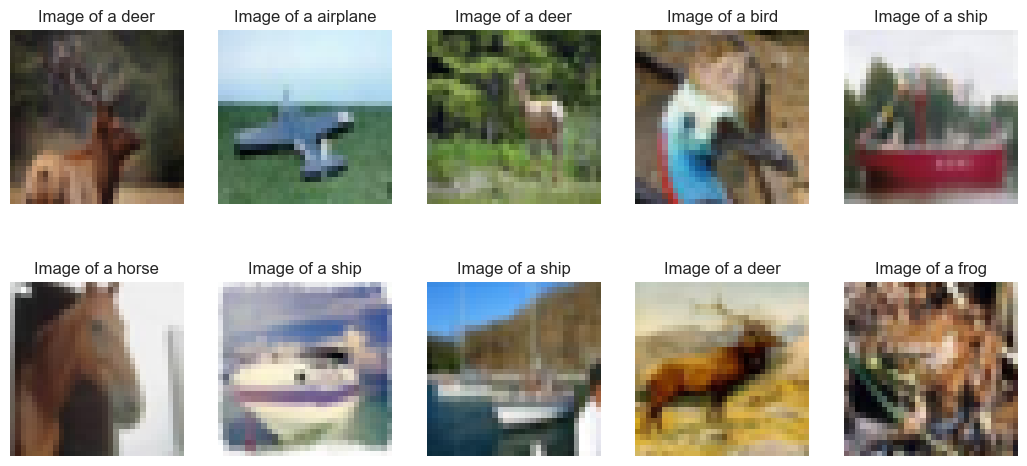

In [4]:
n = 10

plt.figure(figsize=(13, 6))
for plot_index in range(1, n+1):
  plt.subplot(2, 5, plot_index)
  index = np.random.randint(low=0, high=len(X_train))
  plt.imshow(X_train[index])
  plt.title("Image of a %s" % label_map[np.argmax(y_train[index])])
  plt.axis('off')
plt.show()

**Consigne** : Standardiser les données en utilisant la classe [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). On commencera par applatir les images en utilisant la méthode [`reshape`](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html), puis on applique le pré-processing et on termine par reformer la matrice. Attention à bien respecter les dimensions d'origines de l'image.

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.astype(np.float32).reshape(-1, 32 * 32 * 3)).reshape(-1, 32, 32, 3)
X_valid = scaler.transform(X_valid.astype(np.float32).reshape(-1, 32 * 32 * 3)).reshape(-1, 32, 32, 3)

## Modélisation

On souhaite visualiser les différentes courbes d'apprentissages obtenues par différent optimizer. Pour pouvoir le faire, nous allons devoir choisir les optimizers à comparer et lancer l'entraîner de plusieurs modèles. Commençons par définir une architecture avec une fonction de sorte à pouvoir simplement générer des modèles lors de la comparaisons entre les optimizers.

**Consigne** : Définir une fonction `get_model` qui ne prend pas de paramètre et qui renvoie un modèle convolutionnel de moins de 200k paramètres en utilisant des couches de régularisations au choix.

In [6]:
def get_model():
    model = keras.models.Sequential([
        keras.layers.Input(shape=(32, 32, 3)),
        keras.layers.Conv2D(filters=32, kernel_size=5, padding="valid", activation="relu", kernel_initializer="he_normal"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters=32, kernel_size=5, padding="same", activation="relu", kernel_initializer="he_normal"),
        keras.layers.MaxPool2D(pool_size=2),

        keras.layers.Conv2D(filters=32, kernel_size=5, padding="same", activation="relu", kernel_initializer="he_normal"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters=32, kernel_size=5, padding="same", activation="relu", kernel_initializer="he_normal"),
        keras.layers.MaxPool2D(pool_size=2),

        keras.layers.Flatten(),
        keras.layers.Dense(64, activation="relu", kernel_initializer="he_normal"),
        keras.layers.Dense(32, activation="relu", kernel_initializer="he_normal"),
        keras.layers.Dense(10, activation="softmax", kernel_initializer="he_normal")
    ])
    return model

model = get_model()
model.summary

2024-09-14 12:32:01.719009: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-09-14 12:32:01.719026: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-09-14 12:32:01.719031: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-09-14 12:32:01.719048: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-14 12:32:01.719060: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<bound method Model.summary of <Sequential name=sequential, built=True>>

Nous avons modifié la structure de *y_train* et *y_valid*, nous devons adapter la fonction de perte à optimiser en conséquence. Cette fois on considérera la fonction de perte [`CategoricalCrossentropy`](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class) au lieu de [`SparseCategoricalCrossentropy`](https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class) que l'on utilisait jusqu'à présent.

**Consigne** : Définir une fonction `compile_train` qui prend en paramètre:
* *optimizer_function* : l'instanciation de la classe de l'optimizer
* *learning_rate* : le learning rate associé à l'optimizer
* Et des [kwargs](https://book.pythontips.com/en/latest/args_and_kwargs.html)

La fonction renvoie l'historique d'apprentissage du modèle définit par la fonction `get_model`. La fonction doit compiler le modèle avec l'optimizer définit en paramètre et l'entraîner avec les paramètres définit dans les kwargs.

In [7]:
def compile_train(optimizer_function, learning_rate, **kwargs):
    optimizer = optimizer_function(learning_rate=learning_rate)
    model = get_model()
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), **kwargs)
    return history

**Consigne** : Valider le bon fonctionnement de la fonction `compile_train` sur quelques époques.

In [8]:
batch_size = 256
n_epochs = 5
learning_rate = 5e-4
optimizer = keras.optimizers.SGD

history = compile_train(optimizer_function=optimizer, learning_rate=learning_rate, batch_size=batch_size, epochs=n_epochs)

Epoch 1/5


2024-09-14 12:32:02.248307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.1269 - loss: 2.5847 - val_accuracy: 0.1666 - val_loss: 2.2542
Epoch 2/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.1760 - loss: 2.2543 - val_accuracy: 0.2042 - val_loss: 2.1738
Epoch 3/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.2125 - loss: 2.1519 - val_accuracy: 0.2349 - val_loss: 2.0998
Epoch 4/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.2363 - loss: 2.0769 - val_accuracy: 0.2602 - val_loss: 2.0358
Epoch 5/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.2675 - loss: 2.0037 - val_accuracy: 0.2790 - val_loss: 1.9809


Pour s'affranchir un peu de l'aléatoire, nous proposons de lancer trois fois les différents schéma d'optimisation pour les comparer. La légende sera composée du nom de l'optimizer et la valeur du learning rate sélectionnée. La classe [`optimizer`](https://keras.io/api/optimizers/#optimizer-class) de Keras permet d'obtenir ces informations comme suit:

In [9]:
name = optimizer.__name__
label = f"{name} - {learning_rate:.06}"
print(label)

SGD - 0.0005


**Consigne** : Écrire une boucle d'entraînement qui va stocker dans une liste les courbes d'apprentissage. Chaque élément de la liste correspondra à un dictionnaire avec pour clé:
* *type*: le nom de l'optimizer
* *history*: l'historique d'apprentissage

In [10]:
n_epochs = 50
batch_size = 528
comparisons_number = 3
learning_rate=5e-4
verbose = 0
results = []


optimizers = [
  keras.optimizers.SGD,
  keras.optimizers.RMSprop,
  keras.optimizers.Adagrad,
  keras.optimizers.Adam
]

for index in range(comparisons_number):
  print("Comparison %d :" % (index+1), end=" ")
  for optimizer in optimizers:
    label = f"{optimizer.__name__} - {learning_rate:.06}"
    print("%s..." % label, end= " ")
    history = compile_train(optimizer_function=optimizer, learning_rate=learning_rate, batch_size=batch_size, epochs=n_epochs, verbose=verbose)
    result = {"type": label, "history": pd.DataFrame(history.history)}
    results.append(result)
  print()

Comparison 1 : SGD - 0.0005... RMSprop - 0.0005... Adagrad - 0.0005... Adam - 0.0005... 
Comparison 2 : SGD - 0.0005... RMSprop - 0.0005... Adagrad - 0.0005... Adam - 0.0005... 
Comparison 3 : SGD - 0.0005... RMSprop - 0.0005... Adagrad - 0.0005... Adam - 0.0005... 


Il faut maintenant visualiser les résultats. Commençons par préparer les données.

**Consigne** : Définir une fonction `agregate_result` qui prend en paramètre:
* *results*: le dictionnaire de résultat, au format décrit précédemment
* *network_type*: chaîne de caractère identifiant le type de réseau
* *metric_name*: le nom de la métrique d'intérêt

La fonction renverra deux matrices de tailles (nombre de comparaisons, nombre d'époque) : une pour le dataset d'entraînement et une pour le dataset de validation. On concatène donc les différentes courbes d'apprentissage.

In [11]:
def agregate_result(results, network_type, metric_name):
  training = np.zeros((comparisons_number, n_epochs))
  validation = np.zeros((comparisons_number, n_epochs))
  index = 0
  for result in results:
    if result["type"] == network_type:
      historic = result["history"]
      training[index] = historic[metric_name]
      validation[index] = historic["val_%s" % metric_name]
      index += 1
  return training, validation

**Consigne** : Visualiser les courbes d'apprentissage en faisant apparaître des intervals de confiance. On prendra exemple sur la fonction `show_results` du TP précédent. Commenter.

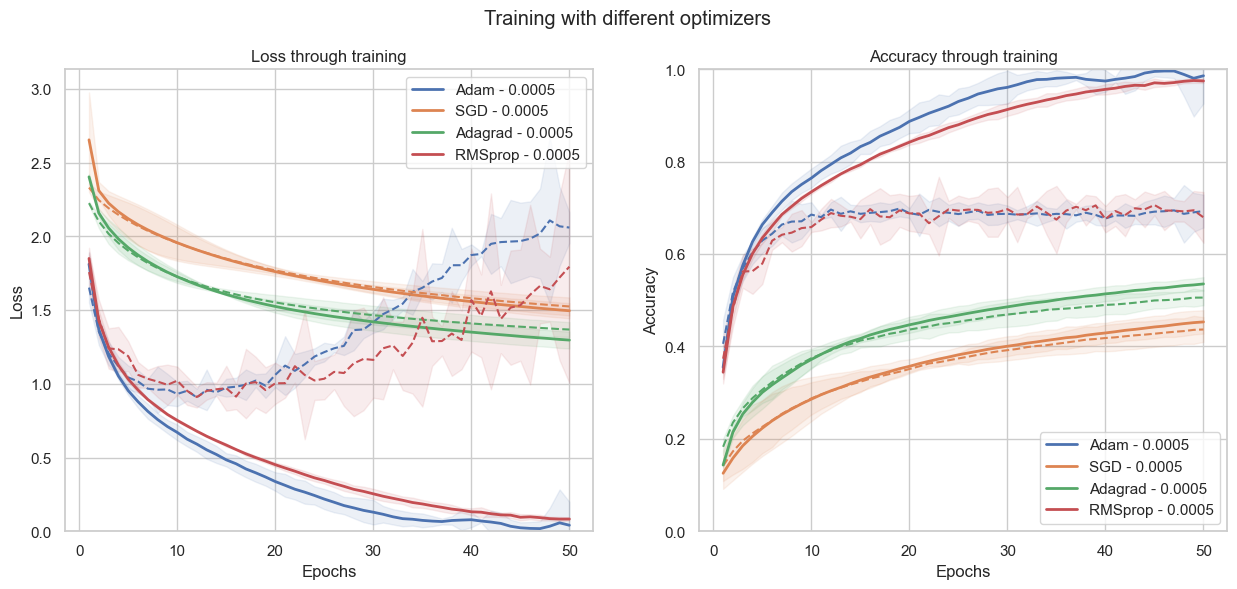

In [12]:
epochs = range(1, n_epochs+1)

figure, (axis_1, axis_2) = plt.subplots(1, 2, figsize=(15, 6))

for metric_name, axis in zip(["loss", "accuracy"], [axis_1, axis_2]):

  for index, network_type in enumerate(list(set(result["type"] for result in results))):
    color = sns.color_palette()[index]
    training, validation = agregate_result(results, network_type, metric_name)
    axis.plot(epochs, training.mean(axis=0), lw=2, label=network_type, color=color)
    axis.fill_between(epochs, training.mean(axis=0)-3*training.std(axis=0), training.mean(axis=0)+3*training.std(axis=0), color=color, alpha=0.1)
    axis.plot(epochs, validation.mean(axis=0), ls="--", color=color)
    axis.fill_between(epochs, validation.mean(axis=0)-3*validation.std(axis=0), validation.mean(axis=0)+3*validation.std(axis=0), color=color, alpha=0.1)

  axis.set_ylabel(metric_name.capitalize())
  axis.set_xlabel("Epochs")
  axis.set_title("%s through training" % metric_name.capitalize())
  axis.legend()
  
  axis_1.set_ylim(bottom=0)
  axis_2.set_ylim(0, 1)


plt.suptitle("Training with different optimizers")
plt.show()

On a un overfitting fort pour RMSProp et Adam et qui intervient tôt dans l'entraînement. On a un entraînement beaucoup plus lent pour SGD et Adagrad mais il progresse encore. Du côté de l'accuracy, avec un peu plus d'époque il semblerait que l'on puisse encore progresser.

## Pour continuer

Choisir une ou plusieurs pistes de recherche parmi les suivantes. Il est possible de choisir une autre direction, mais elle doit être validé auparavant.

1. Nous avons utilisé un learning rate fixe et dans le cours nous avons parlé d'échéancier. Comparer les deux approches, puis se poser la question de l'importance (ou non) d'un phase de warmup.
2. Le [`Dropout`](https://keras.io/api/layers/regularization_layers/dropout/) permet de régulariser un réseau de neurones. Comparer un réseau avec et sans dropout, puis se poser la question de l'importance de la magnitude et du placement d'une couche dropout.